# Machine learning tools for dimensionality reduction: PCA and clustering

When using battery-constrained sensors, one wants to reduce the amount of information to be transmitted - to save energy resources - while guaranteeing the correct recovery of the data at the receiver end. This is achieved through the implementation of dimensionality reduction tools that extract and retain the most relevant information from the data. In this notebook, you will implement and evaluate different approaches.  

In this notebook, you will:
1. implement the principal component analysis (PCA) algorithm from scratch
2. use the PCA and K-means functions provided by Python developers through the scikit-learn library
3. perform dimensionality reduction on time-series
4. apply the algorithms to ECG signals acquired through the POLAR sensor

## Import statements
IMPORTANT: `ModuleNotFoundError` usually means you miss some packets. Install them with `pip` or `conda`.

In [1]:
# Scientific packages
import numpy as np
import scipy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.signal import resample

# Plot packages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Custom functions
from hda_utils import load_dataset, segment_ECG, matrix_to_signal

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,10]
np.random.seed(1)

## Load and visualize PPG and ECG signals

In [2]:
# Load signals
ppg_signal, ecg_signal = load_dataset()

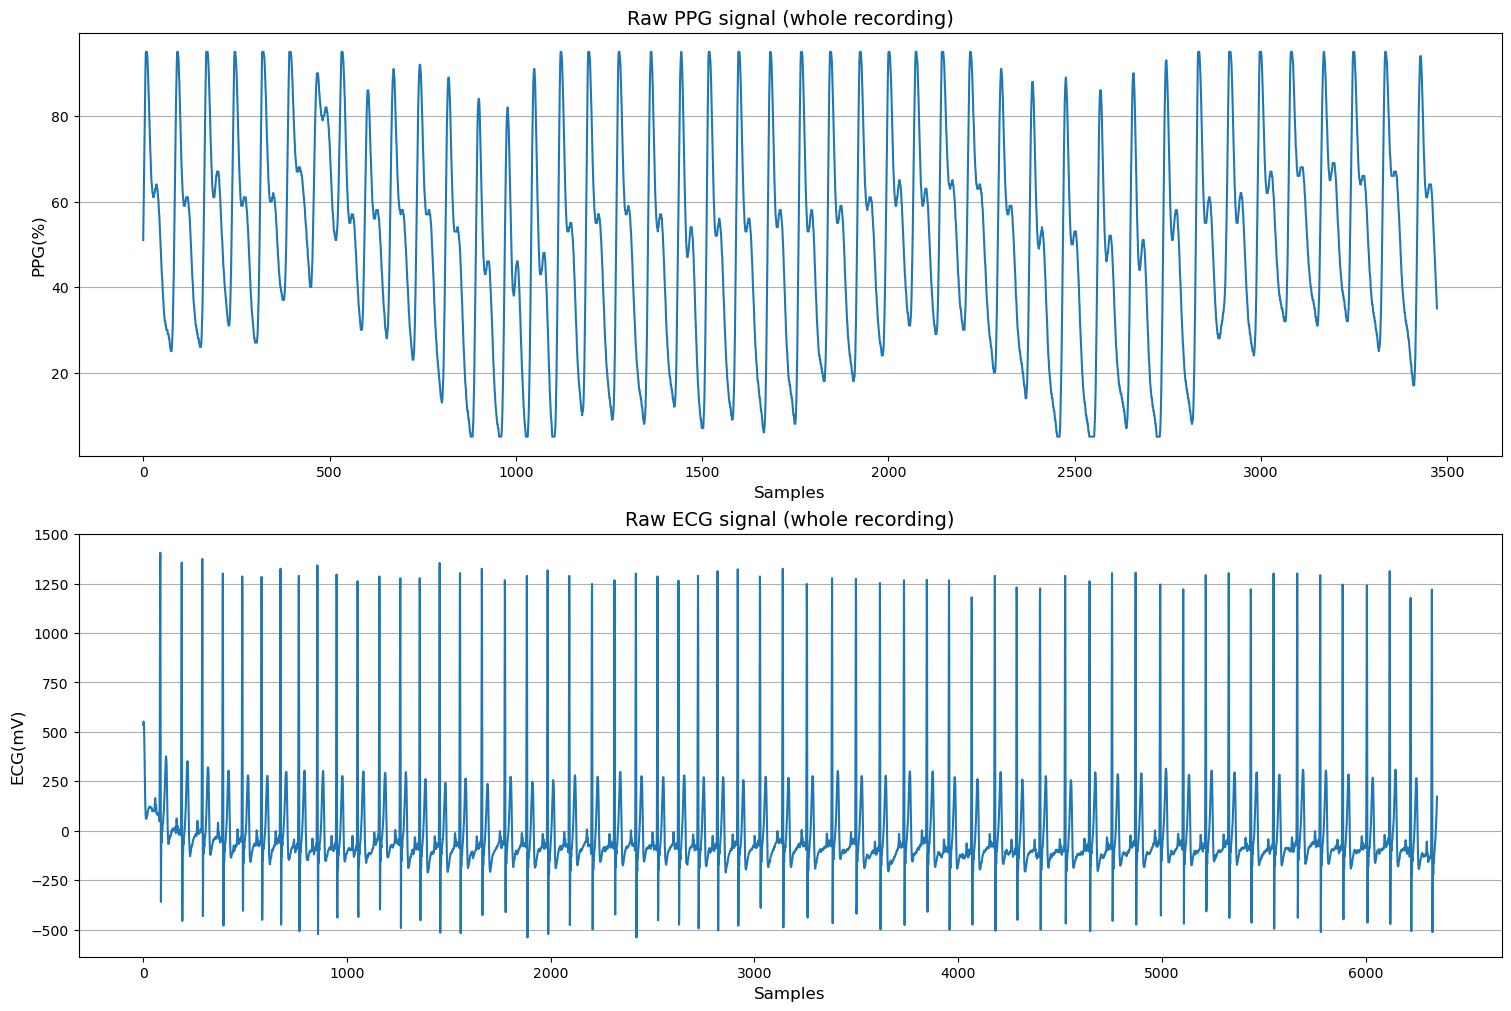

In [3]:
# Plot 
fig = plt.figure(constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.plot(ppg_signal)
ax1.set_title('Raw PPG signal (whole recording)', fontsize=14)
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('PPG(%)', fontsize=12)
ax1.grid(axis='y')

ax2.plot(ecg_signal)
ax2.set_title('Raw ECG signal (whole recording)', fontsize=14)
ax2.set_xlabel('Samples', fontsize=12)
ax2.set_ylabel('ECG(mV)', fontsize=12)
ax2.grid(axis='y')

plt.show()

## ECG segmentation

In this notebook, we focus on the ECG signal. To start with, we need to implement a way to segment the signal into beats. 

<img src="images/beat.png" style="width:800px;">
<caption><center><u>Figure 1</u>: one heart beat extracted from the ECG signal</center></caption>

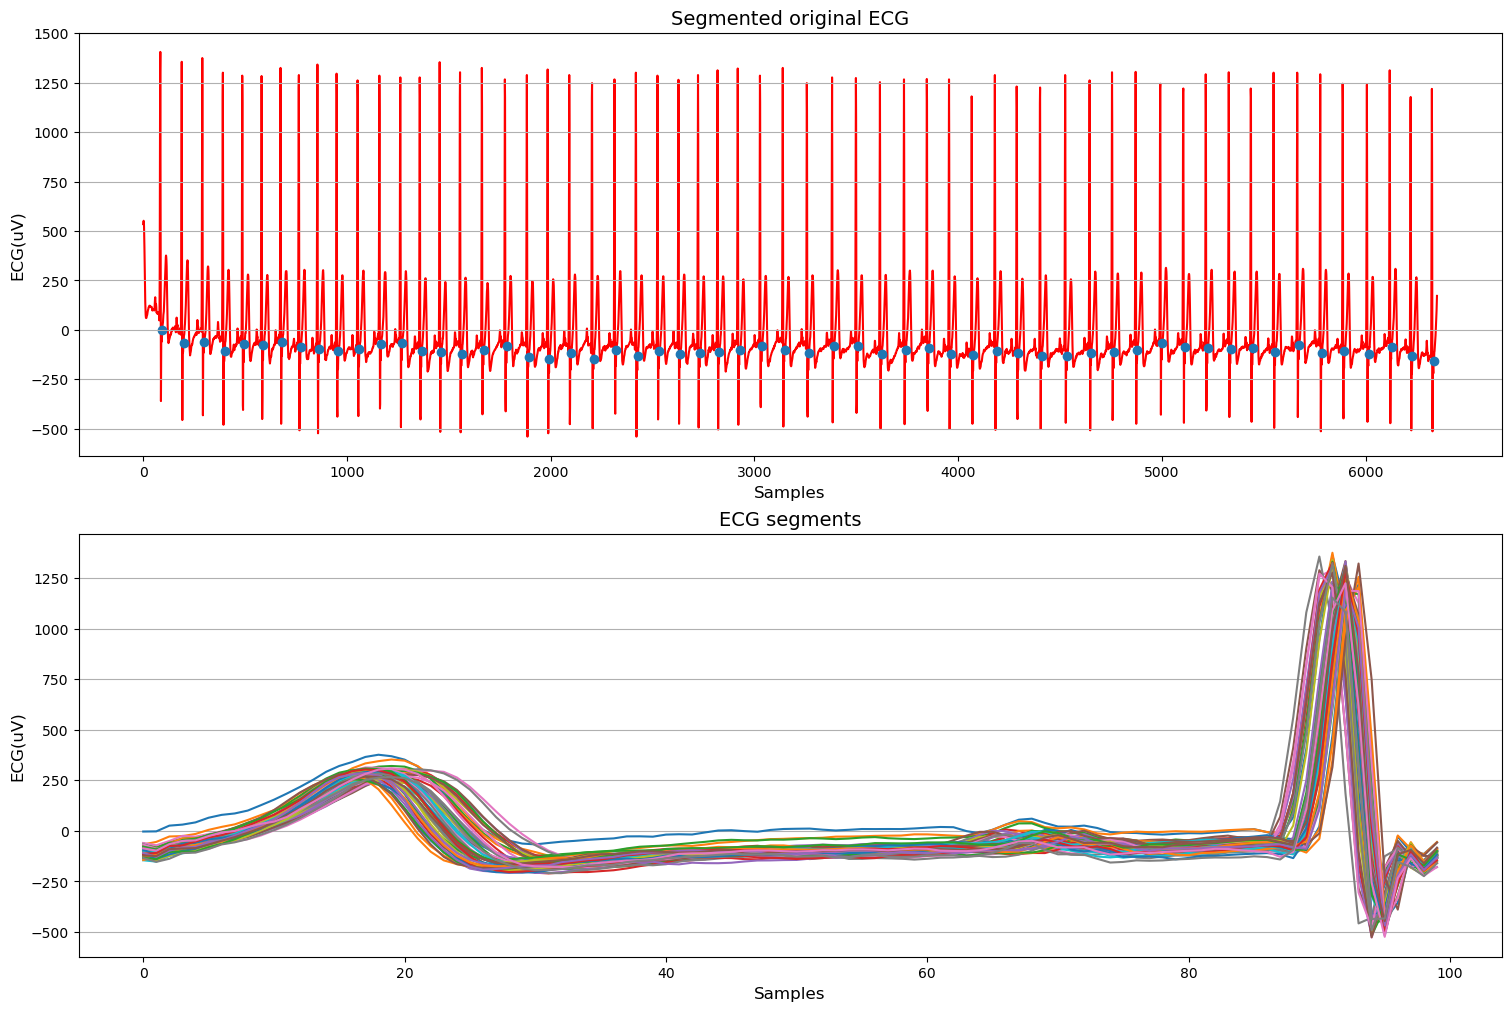

In [4]:
# ECG segmentation
ecg_mat, r_peaks, original_len = segment_ECG(ecg_signal)


# Plot segments
fig1 = plt.figure(constrained_layout=True)
gs = GridSpec(2, 1, figure=fig1)
ax1 = fig1.add_subplot(gs[0, :])
ax2 = fig1.add_subplot(gs[1, :])

ax1.plot(ecg_signal, 'r', zorder=0)
ax1.scatter(r_peaks, list(ecg_signal[r_peaks].T[0]), zorder=1)
ax1.set_title('Segmented original ECG', fontsize=14)
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('ECG(uV)', fontsize=12)
ax1.grid(axis='y')

ax2.plot(ecg_mat.T)
ax2.set_title('ECG segments', fontsize=14)
ax2.set_xlabel('Samples', fontsize=12)
ax2.set_ylabel('ECG(uV)', fontsize=12)
ax2.grid(axis='y')

plt.show()

Next, an important step of data preprocessing for machine learning algorithms is normalization. 
Here we use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class in Python that provides functions to normalize the data. In the following cell, normalize the ECG data by using the `StandardScaler().fit(ecg_mat)` and `scaler.transform(ecg_mat)`.

In [5]:
# Normalize data along feature axis (2 lines of code)
scaler = StandardScaler().fit(ecg_mat)
ecg_mat_norm = scaler.transform(ecg_mat)

In [6]:
# Split data
train_fraction = 0.8

# Vector to elect only test data from original signal
x_axis = np.arange(r_peaks[int(np.floor(len(r_peaks)*train_fraction))-1], r_peaks[-1], 1) 
print(original_len)
ecg_mat_train, ecg_mat_test, original_len_train, original_len_test = train_test_split(ecg_mat_norm, original_len, train_size=train_fraction, shuffle=False)

[105, 101, 101, 95, 95, 93, 89, 92, 94, 103, 107, 102, 96, 98, 100, 107, 113, 108, 102, 106, 112, 110, 105, 106, 103, 96, 96, 99, 109, 112, 118, 124, 117, 118, 118, 112, 109, 111, 114, 107, 115, 123, 120, 110, 116, 120, 113, 111, 113, 108, 112, 116, 113, 110, 119, 112, 102, 105]


## 1 - Principal component analysis (PCA)

The goal of PCA is to find a new basis to project the data in the dataset $X \in \mathbb{R}^{n \times m}$. The new basis is obtained as a linear combination of the vectors in the original basis and the dataset after applying PCA is obtained as $Y=XP$ with $P \in \mathbb{R}^{m \times m}$ and $Y \in \mathbb{R}^{n \times m}$.

After performing PCA, we can retain a lower number of dimensions $d < m$ to reduce the dimensionality of the input space, obtaining $\hat{Y}=XW$ with $W \in \mathbb{R}^{m \times d}$.

The objective is to minimize the mean square error between $\hat{X} = \hat{Y}\hat{W}$ and $X$, where $\hat{W} \in \mathbb{R}^{d \times m}$ is the matrix of reverse transformation:

$$\|\hat{X} - X\|^2_2$$


In geometric terms, we want to find $d$ axes along which most of the variance occurs. 

### 1a - implement your own dimensionality reduction algorithm based on PCA
The steps are the following:

1. normalize the data (in our case, already done above by StandardScaler)
2. compute the covariance matrix using the [`cov` function](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) of the numpy library: take a look at the `rowvar` argument to properly compute the covariance (in our case the rows of the matrix are the observations and the columns represent the variables/features)
3. perform eigendecomposition using the [`linalg.eigh` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html#scipy-linalg-eigh) of the scipy library: the function returns the eigenvectors and eigenvalues sorted based on the value of the eigenvalues 
4. select the `num_components` strongest eigenvectors to be retained

The steps until here allow creating the model for dimensionality reduction through PCA. The training data is used to make the model learn which are the components of the data and their relevance in the definition of the data.

Once the model has been trained through steps 2-4, it can be used in real-time to process new data and obtain a compressed version of it. The compressed data are built by retaining the strongest components found through PCA. As stated before, this compression step can be helpful when data needs to be transmitted over a communication system and we want to reduce the amount of information to send for different reasons such as latency, battery constraints, or network congestion issues. Therefore, the last step is:

5. apply the transformation to the test data and go back to the original reference system, see the mathematical formulation above

Complete the following function by substituting the 'None' with the correct statements.

In [7]:
def my_PCA(X_train, X_test, num_components, scaler, original_len=None):

    covariance_mat = np.cov(X_train, rowvar=False)
    
    eigenvalues, eigenvectors = scipy.linalg.eigh(covariance_mat)
    sorted_indeces = np.flip(np.argsort(eigenvalues))
    P = eigenvectors[:, sorted_indeces]
    print(P.shape)
    W = P[:, 0:num_components]
    Y_hat = np.dot(X_test, W)
    W_hat = W.T
    X_hat = np.dot(Y_hat, W_hat)
    
    approx_data = scaler.inverse_transform(X_hat)
    ecg_sig_rec = matrix_to_signal(approx_data, original_len)
    
    return ecg_sig_rec

In [8]:
# No compression
n_components_nocomp = ecg_mat_train.shape[0]
ecg_sig_nocomp = my_PCA(ecg_mat_train, ecg_mat_test, n_components_nocomp, scaler, original_len_test)

# Compressed signal
n_components_comp1 = 3
ecg_sig_comp1 = my_PCA(ecg_mat_train, ecg_mat_test, n_components_comp1, scaler, original_len_test)

# More compressed signal
n_components_comp2 = 1
ecg_sig_comp2 = my_PCA(ecg_mat_train, ecg_mat_test, n_components_comp2, scaler, original_len_test)

(100, 100)
(100, 100)
(100, 100)


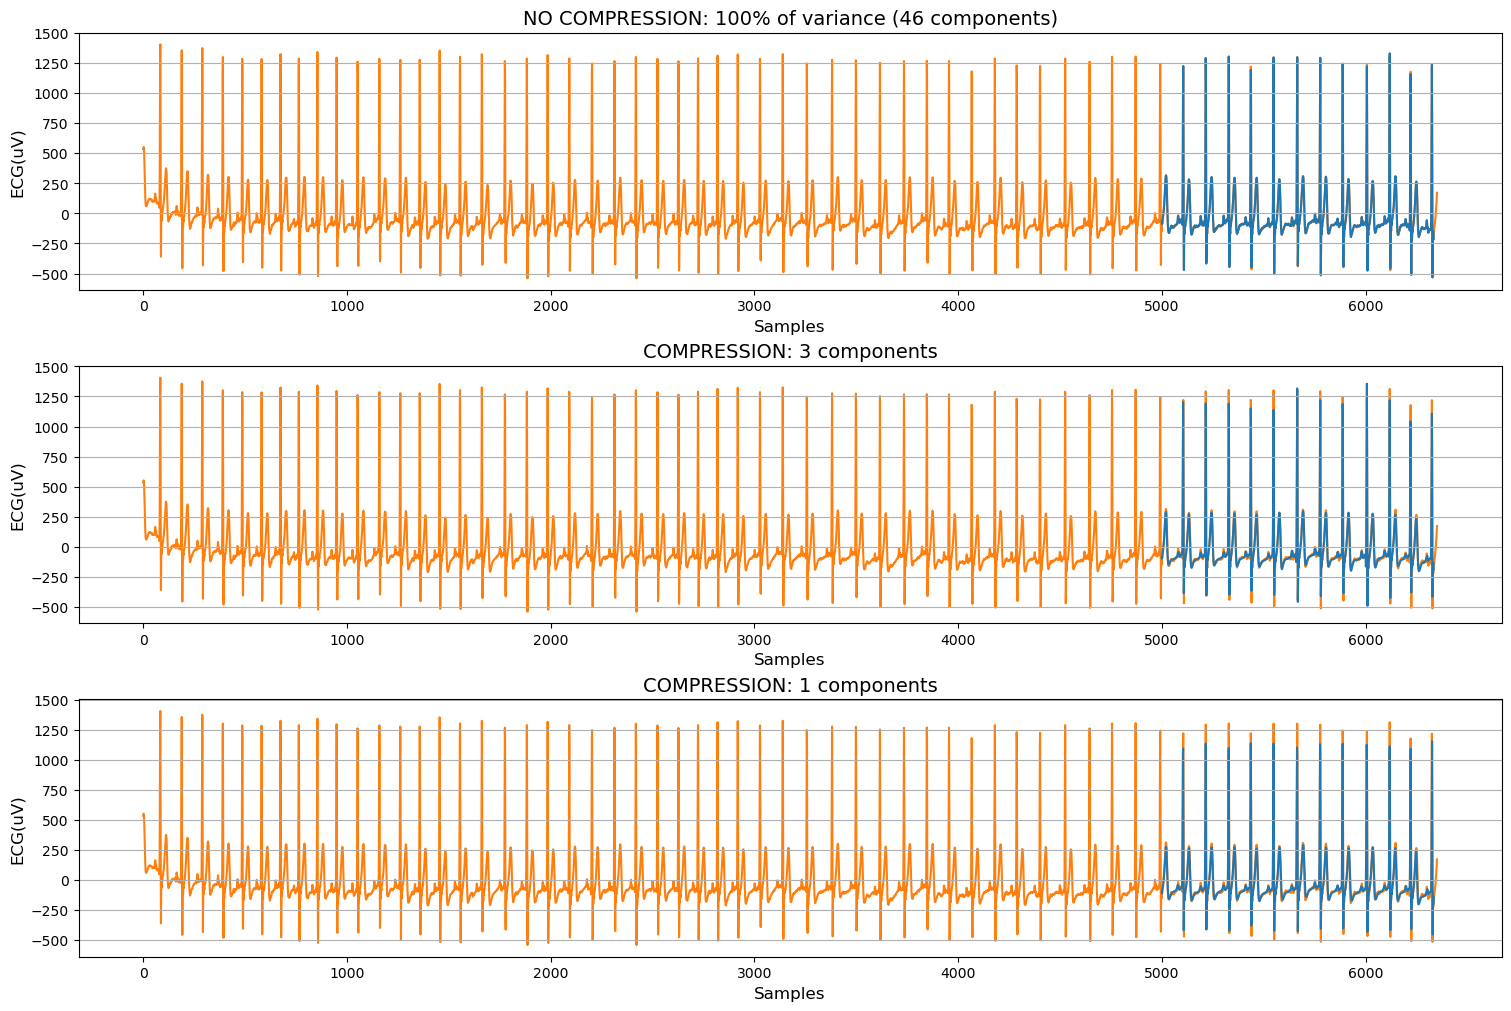

In [9]:
fig2 = plt.figure(constrained_layout=True)
gs = GridSpec(3, 1, figure=fig2)
ax1 = fig2.add_subplot(gs[0, :])
ax2 = fig2.add_subplot(gs[1, :])
ax3 = fig2.add_subplot(gs[2, :])

# No compression
ax1.plot(x_axis, ecg_sig_nocomp, zorder=1)
ax1.plot(ecg_signal, zorder=0)
ax1.set_title('NO COMPRESSION: 100% of variance (' + str(n_components_nocomp) + ' components)', fontsize=14)
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('ECG(uV)', fontsize=12)
ax1.grid(axis='y')

# Compressed signal
ax2.plot(x_axis, ecg_sig_comp1, zorder=1)
ax2.plot(ecg_signal, zorder=0)
ax2.set_title('COMPRESSION: ' + str(n_components_comp1) + ' components', fontsize=14)
ax2.set_xlabel('Samples', fontsize=12)
ax2.set_ylabel('ECG(uV)', fontsize=12)
ax2.grid(axis='y')

# More compressed signal
ax3.plot(x_axis, ecg_sig_comp2, zorder=1)
ax3.plot(ecg_signal, zorder=0)
ax3.set_title('COMPRESSION: ' + str(n_components_comp2) + ' components', fontsize=14)
ax3.set_xlabel('Samples', fontsize=12)
ax3.set_ylabel('ECG(uV)', fontsize=12)
ax3.grid(axis='y')

plt.show()

### 1b - use the PCA dimensionality reduction algorithm from Python developers
Use the [sklearn.decomposition.PCA class](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from the scikit-learn library. The steps are the following:

1. import the library (already done, see the "Import statements" section above)
2. create a new object of the class with `PCA(...)`: using this class you can specify the number of components to retain (as you did with `my_PCA` function) or the explainable variance (take a look at the documentation!). In this part of the notebook, you will specify the explainable variance you want to keep.
3. fit the PCA model on the data $X$ using the [fit method](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit): this provides you with $Y$ being the new representation of $X$ using a new basis. Use: `pca.fit(X_train)`

As already mentioned above, the steps until here are necessary to create the model and hence are performed using the training data. 

At this point we can use the built model to compress new data (test data):

4. compress the test data using the compressed PCA transformation with [transform method](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.transform). Use: `pca.transform(X_test)`
5. go back to the original space using the [inverse_transform method](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.inverse_transform). Use: `pca.inverse_transform(Y_hat)`

In [10]:
def PCA_variancefraction(X_train, X_test, scaler, original_len, variance_fraction=None):
    
    # Create a PCA model with the required explained variance
    pca = PCA(variance_fraction)
    # Fit the model to the train data
    pca.fit(X_train)
    
    n_components = pca.n_components_ 
    
    # Transform the test data
    Y_hat = pca.transform(X_test)
    # Go back to original space
    X_hat = pca.inverse_transform(Y_hat)
    
    approx_data = scaler.inverse_transform(X_hat)
    ecg_sig_rec = matrix_to_signal(approx_data, original_len)
    
    return ecg_sig_rec, n_components

In [11]:
# Use the function considering two values as example for the variance
variance_fractions = [.9, .93]

# No compression
ecg_sig_nocomp, n_components_nocomp = PCA_variancefraction(ecg_mat_train, ecg_mat_test, scaler, original_len_test, None)

# Compressed signal
ecg_sig_comp1, n_components_comp1 = PCA_variancefraction(ecg_mat_train, ecg_mat_test, scaler, original_len_test, variance_fractions[0])

# More compressed signal
ecg_sig_comp2, n_components_comp2 = PCA_variancefraction(ecg_mat_train, ecg_mat_test, scaler, original_len_test, variance_fractions[1])

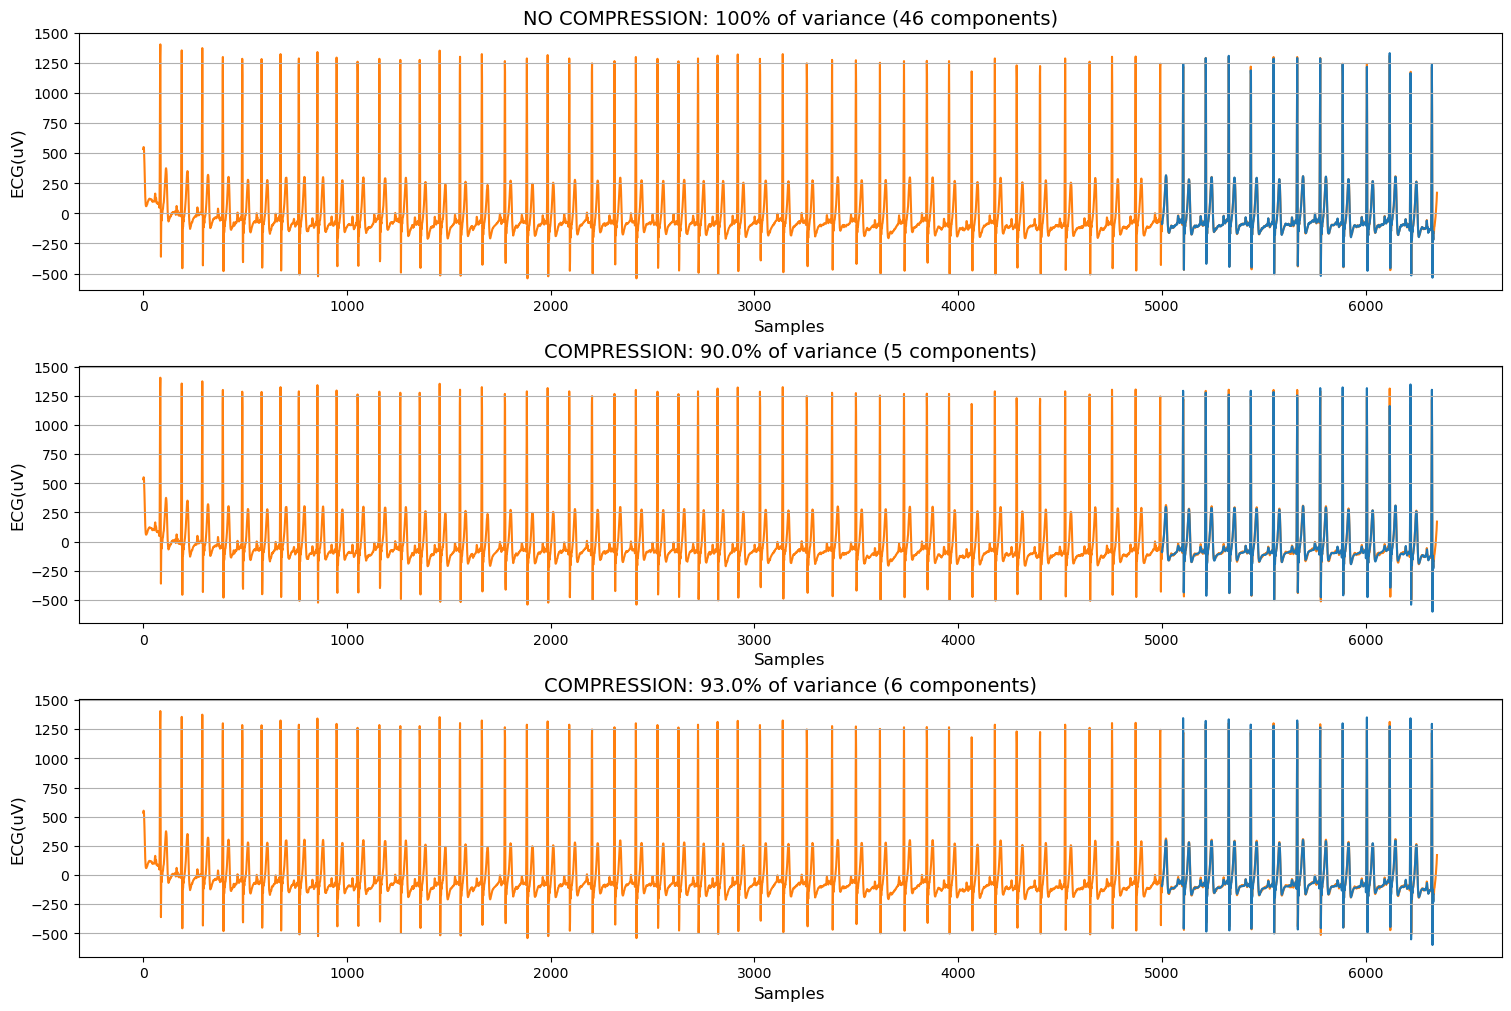

In [12]:
fig2 = plt.figure(constrained_layout=True)
gs = GridSpec(3, 1, figure=fig2)
ax1 = fig2.add_subplot(gs[0, :])
ax2 = fig2.add_subplot(gs[1, :])
ax3 = fig2.add_subplot(gs[2, :])

# No compression
ax1.plot(x_axis, ecg_sig_nocomp, zorder=1)
ax1.plot(ecg_signal, zorder=0)
ax1.set_title('NO COMPRESSION: 100% of variance (' + str(n_components_nocomp) + ' components)', fontsize=14)
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('ECG(uV)', fontsize=12)
ax1.grid(axis='y')

# Compressed signal
ax2.plot(x_axis, ecg_sig_comp1, zorder=1)
ax2.plot(ecg_signal, zorder=0)
ax2.set_title('COMPRESSION: ' + str(variance_fractions[0]*100) + '% of variance (' + str(n_components_comp1) + ' components)', fontsize=14)
ax2.set_xlabel('Samples', fontsize=12)
ax2.set_ylabel('ECG(uV)', fontsize=12)
ax2.grid(axis='y')

# More compressed signal
ax3.plot(x_axis, ecg_sig_comp2, zorder=1)
ax3.plot(ecg_signal, zorder=0)
ax3.set_title('COMPRESSION: ' + str(variance_fractions[1]*100) + '% of variance (' + str(n_components_comp2) + ' components)', fontsize=14)
ax3.set_xlabel('Samples', fontsize=12)
ax3.set_ylabel('ECG(uV)', fontsize=12)
ax3.grid(axis='y')

plt.show()

## 1c - Error computation

The root-mean-square error (RMSE) metric can be used to evaluate the differences between the values predicted by a model and the actual values (the ground truth). 

It is calculated as:
$$RMSE = \|\hat{X} - X\|^2_2$$
where $\hat{X}$ is the predicted data and $X$ represents the observed data.

Properties of RMSE: 
1. non-negative
2. RMSE = 0 -> no error (almost never achieved in practice) 
3. In general, a lower RMSE is better than a higher one, there is no upper limit.
4. As the measure depends on the scale of the data, the comparison across different types of data requires a normalization step.
5. RMSE is sensitive to outliers.
6. It is the measure usually used in the implementation of K-means and others clustering techniques.

To obtain the error, you can use the [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) method of sklearn library.

In [13]:
# The error is computed on the test dataset
test_ecg_signal = ecg_signal[x_axis]

nocomp_error = mean_squared_error(test_ecg_signal, ecg_sig_nocomp, squared=False)
comp1_error = mean_squared_error(test_ecg_signal, ecg_sig_comp1, squared=False)
comp2_error = mean_squared_error(test_ecg_signal, ecg_sig_comp2, squared=False)

print('NO COMPRESSION - RMSE: \t' + str(nocomp_error))
print('COMPRESSION, ' + str(variance_fractions[0]*100) + '% of variance - RMSE: \t' + str(comp1_error))
print('COMPRESSION, ' + str(variance_fractions[1]*100) + '% of variance - RMSE: \t' + str(comp2_error))

NO COMPRESSION - RMSE: 	6.097001803071364
COMPRESSION, 90.0% of variance - RMSE: 	30.449297570196258
COMPRESSION, 93.0% of variance - RMSE: 	30.541946679538196


In [14]:
def plot_errors_comps(data_train, data_test, scaler, original_len_test, x_axis, nocomp_error, n_components_nocomp, variance_fractions):
    variance_fractions_plot = 1 - np.logspace(max(np.log10(2)-1, (np.log10(1-min(variance_fractions)))), np.log10(1)-3, 1000, endpoint=True)
    n_components_plot = np.zeros(variance_fractions_plot.shape[0])
    errors_plot = np.zeros(variance_fractions_plot.shape[0])

    for i in range(variance_fractions_plot.shape[0]):
        ecg_sig_plot, n_components_plot[i] = PCA_variancefraction(data_train, data_test, scaler, original_len_test, variance_fractions_plot[i])
        errors_plot[i] = mean_squared_error(test_ecg_signal, ecg_sig_plot, squared=False)

    n_components_plot = np.hstack((n_components_plot, n_components_nocomp)) 
    errors_plot = np.hstack((errors_plot, nocomp_error))
    variance_fractions_plot = np.hstack((variance_fractions_plot, 1))

    return n_components_plot, errors_plot, variance_fractions_plot

In [15]:
n_components_plot, errors_plot, variance_fractions_plot = plot_errors_comps(ecg_mat_train, ecg_mat_test, scaler, original_len_test, x_axis, nocomp_error, n_components_nocomp, variance_fractions)

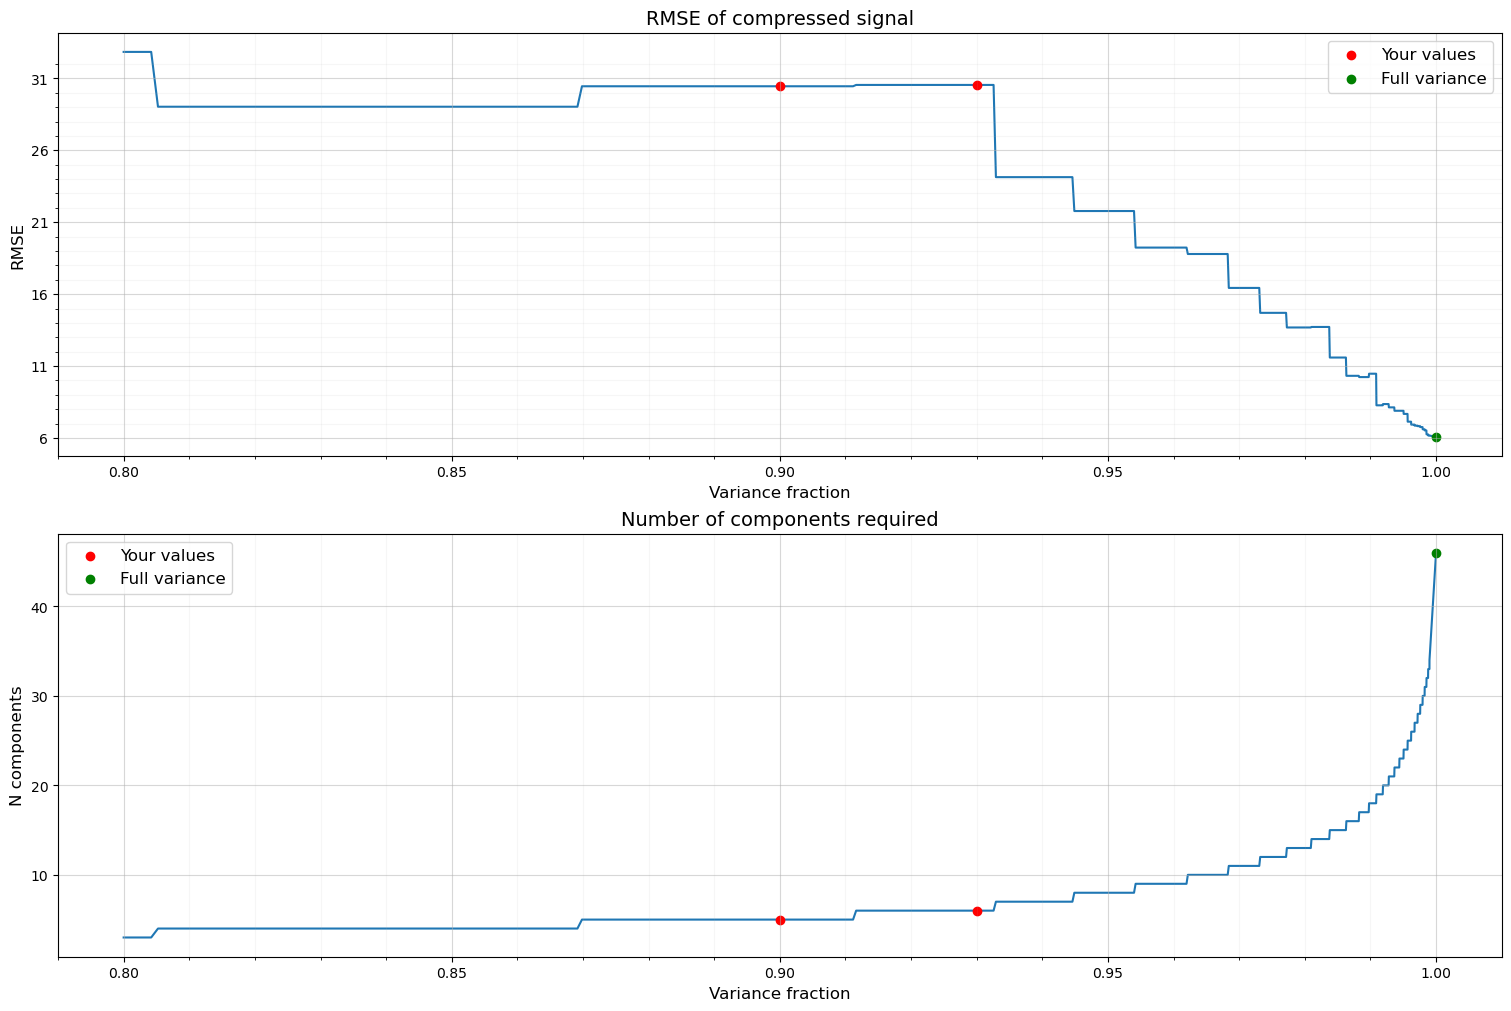

In [16]:
fig3 = plt.figure(constrained_layout=True)
gs = GridSpec(2, 1, figure=fig3)
ax = fig3.add_subplot(gs[0, :])
ax_n = fig3.add_subplot(gs[1, :])

major_ticks_x = np.arange(0, 1.05, 0.05)
minor_ticks_x = np.arange(0, 1.01, .01)
major_ticks_y = np.arange(int(min(errors_plot)), max(errors_plot), 5)
minor_ticks_y = np.arange(int(min(errors_plot)), max(errors_plot), 1)

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax_n.set_xticks(major_ticks_x)
ax_n.set_xticks(minor_ticks_x, minor=True)

ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.5)
ax_n.grid(which='minor', alpha=0.1)
ax_n.grid(which='major', alpha=0.5)

ax.set_xlabel('Variance fraction', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('RMSE of compressed signal', fontsize=14)
ax_n.set_xlabel('Variance fraction', fontsize=12)
ax_n.set_ylabel('N components', fontsize=12)
ax_n.set_title('Number of components required', fontsize=14)

ax.plot(variance_fractions_plot, errors_plot, zorder=0)
ax_n.plot(variance_fractions_plot, n_components_plot, zorder=0)

ax.scatter(variance_fractions, [comp1_error, comp2_error], color='r', zorder=1, label="Your values")
ax.scatter(1, [nocomp_error], color='g', zorder=1, label="Full variance")
ax_n.scatter(variance_fractions, [n_components_comp1, n_components_comp2], color='r', zorder=1, label="Your values")
ax_n.scatter(1, [n_components_nocomp], color='g', zorder=1, label="Full variance")

ax.legend(fontsize=12)
ax_n.legend(fontsize=12)
plt.show()

## 2 - Clustering
 
Compression can be obtained also by means of clustering techniques. 
This is achieved by first obtaining relevant clusters by training a clustering algorithm on the training data.
Next, new data are clustered by using the clusters defined during the training phase. Having obtained the clusters, each signal is coded (substituted) with the centroid word of the associated cluster.

In the transmission scenario, after the dictionary of centroids is created, you can transmit only the index of the word instead of the entire signal.
 
### 2.1 - K-means

In [17]:
# Number of clusters
K = 5

See the sklearn documentation about the K-means clustering:
[k-means](https://scikit-learn.org/stable/modules/clustering.html#k-means)

In [18]:
# Create the model
kmeans = KMeans(n_clusters=K, random_state=0)

# Fit the model
kmeans.fit(ecg_mat_train)

KMeans(n_clusters=5, random_state=0)

In [19]:
# Train labels
train_labels = kmeans.labels_
print("Train labels: " + str(train_labels))

Train labels: [2 2 2 1 1 1 1 1 1 4 3 3 4 4 4 0 3 3 4 3 3 3 3 3 4 4 4 4 3 3 3 3 3 0 0 3 0
 0 3 0 0 0 0 0 0 3]


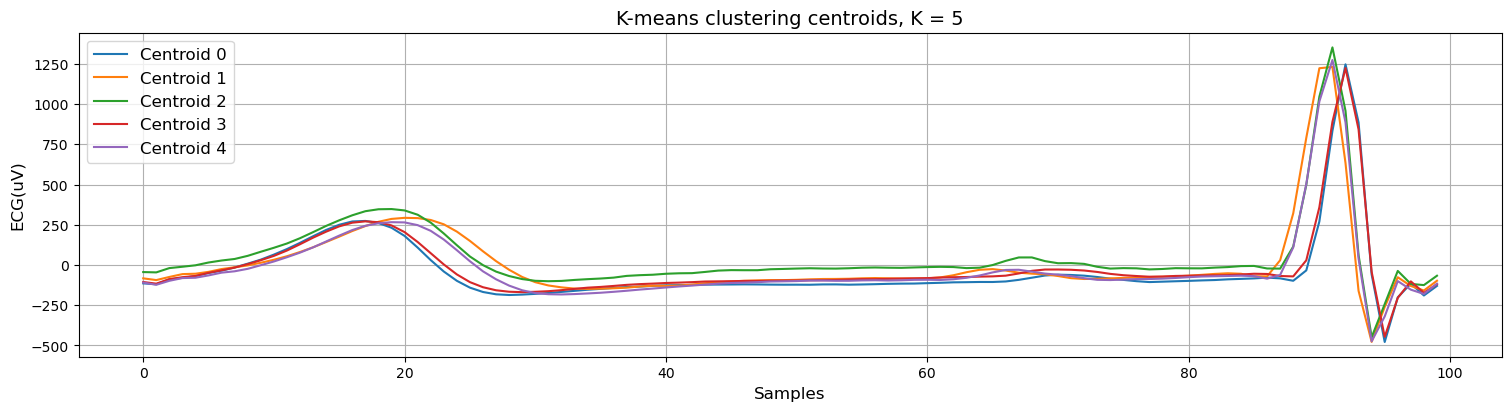

In [20]:
# Plot centroids

centroids = kmeans.cluster_centers_

fig4 = plt.figure(figsize=(15,4), constrained_layout=True)
for i in range(K):
    plt.plot(scaler.inverse_transform(centroids[i,:].reshape(1,-1)).reshape(-1,1), label='Centroid ' + str(kmeans.predict(centroids)[i]))
plt.legend(loc='upper left', fontsize=12)
plt.title('K-means clustering centroids, K = ' + str(K), fontsize=14)
plt.xlabel('Samples', fontsize=12)
plt.ylabel('ECG(uV)', fontsize=12)
plt.grid()
plt.show()

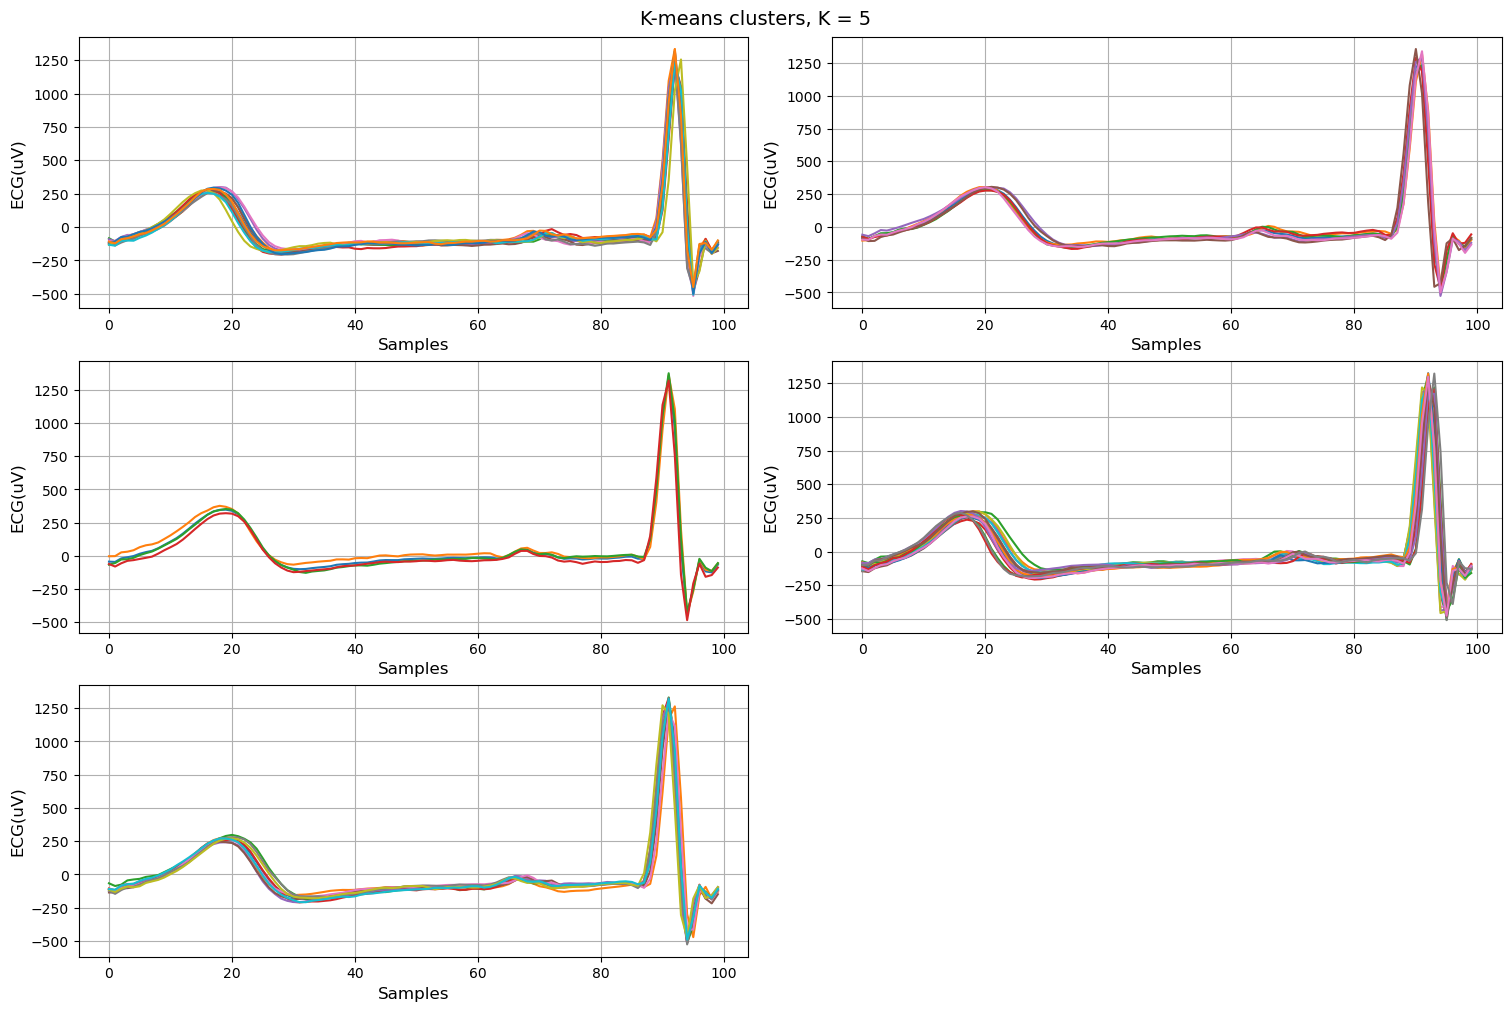

In [21]:
# Plot clusters
# Each cluster consists of similar ECG segments

fig5 = plt.figure(figsize=(15,K*2), constrained_layout=True)
gs = GridSpec(K//2+K%2, 2, figure=fig5)

axs = []
for i in range(K):
    axs.append(fig5.add_subplot(gs[i//2, i%2]))
    axs[i].plot(scaler.inverse_transform(centroids[i,:].reshape(1,-1)).reshape(-1,1))
    axs[i].set_xlabel('Samples', fontsize=12)
    axs[i].set_ylabel('ECG(uV)', fontsize=12)
    axs[i].grid()
for i in range(ecg_mat_train.shape[0]):   
    axs[kmeans.labels_[i]].plot(scaler.inverse_transform(ecg_mat_train[i,:].reshape(1,-1)).reshape(-1,1))
    
plt.suptitle('K-means clusters, K = ' + str(K), fontsize=14)
plt.show()

It's now time to use the trained clustering algorithm. For each segment of the test data, predict the correct cluster using the K-means model.
Use the [predict](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.predict) method as: `kmeans.predict(ecg_mat_test)`

In [22]:
# For each segment to decode, predict the correct cluster
test_labels = kmeans.predict(ecg_mat_test)
test_labels

array([3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 4, 0], dtype=int32)

In [23]:
# Then substitute the original ECG segment with its centroid

ecg_decoded = np.zeros(ecg_mat_test.shape)
centroids_dict = dict(zip(kmeans.predict(centroids), centroids))

for i in range(ecg_mat_test.shape[0]): 
        ecg_decoded[i,:] = scaler.inverse_transform(centroids_dict[test_labels[i]].reshape(1,-1))

In [24]:
# Error calculation
ecg_kmeans_sig = matrix_to_signal(ecg_decoded, original_len_test)
ecg_kmeans_error = mean_squared_error(ecg_signal[x_axis], ecg_kmeans_sig, squared=False)
print('RMSE on test data: ' + str(ecg_kmeans_error))

RMSE on test data: 53.236210492101634


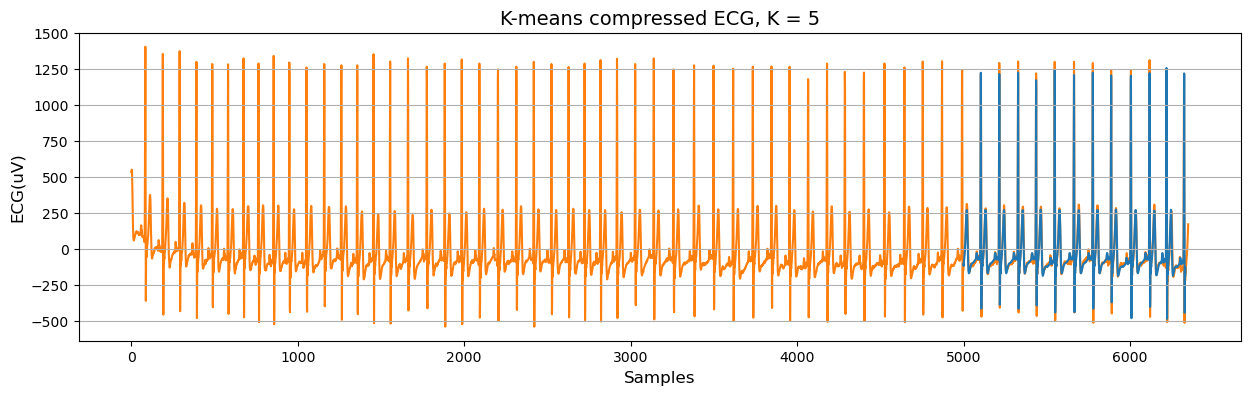

In [25]:
fig6 = plt.figure(figsize=(15,4))
plt.plot(x_axis, ecg_kmeans_sig, zorder=1)
plt.plot(ecg_signal, zorder=0)
plt.title('K-means compressed ECG, K = ' + str(K), fontsize=14)
plt.xlabel('Samples', fontsize=12)
plt.ylabel('ECG(uV)', fontsize=12)
plt.grid(axis='y')
plt.show()

## 3 - Clustering after PCA dimensionality reduction
Now, you will perform the clustering on $\hat{Y}$, the signal in the transformed space obtained with a reduced number of PCA components. 

In [26]:
num_components = 15
pca2 = PCA(n_components=num_components)
pca2.fit(ecg_mat_train)
Y_hat_train = pca2.transform(ecg_mat_train)
Y_hat_test = pca2.transform(ecg_mat_test)

In [27]:
K2 = K

In [28]:
kmeans2 = KMeans(n_clusters=K2, random_state=0).fit(Y_hat_train)

In [29]:
train_labels = kmeans2.labels_
print("Train labels: " + str(train_labels))

Train labels: [2 2 2 1 1 1 1 1 1 4 3 3 4 4 4 0 3 3 4 3 3 3 3 3 4 4 4 4 3 3 3 3 3 0 0 3 0
 0 3 0 0 0 0 0 0 3]


In [30]:
test_labels = kmeans2.predict(Y_hat_test)
print("Test labels: " + str(test_labels))

Test labels: [3 3 3 3 0 3 3 3 0 3 0 0]


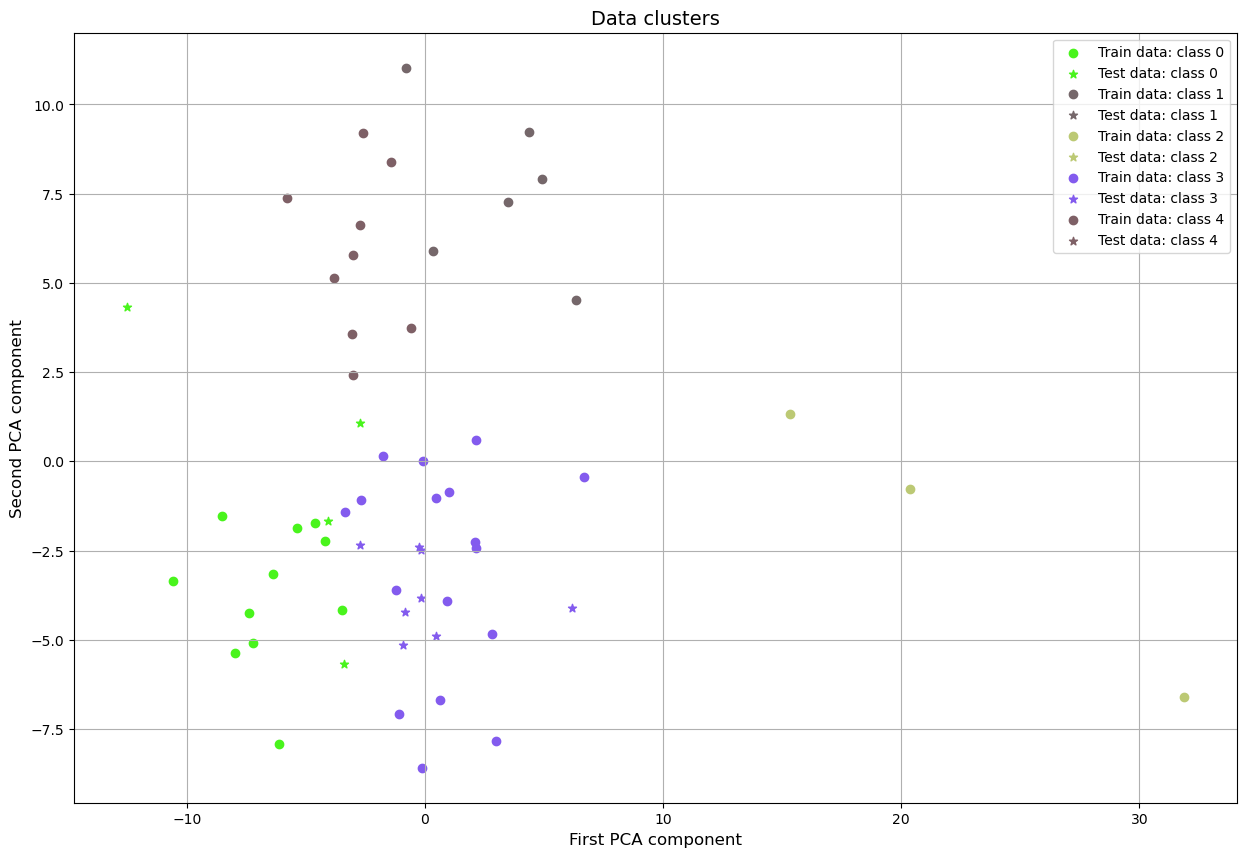

In [31]:
fig, ax1 = plt.subplots(ncols=1)

from random import randint
colors = []

for i in range(K2):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

for l in range(K2):
    ax1.scatter(
        Y_hat_train[train_labels == l, 0],
        Y_hat_train[train_labels == l, 1],
        color=colors[l],
        label="Train data: class %s" % l,
        marker='o'
    )
    ax1.scatter(
        Y_hat_test[test_labels == l, 0],
        Y_hat_test[test_labels == l, 1],
        color=colors[l],
        label="Test data: class %s" % l,
        marker='*'
    )
    
    ax1.legend()
    ax1.set_title("Data clusters", fontsize=14)
    ax1.set_xlabel("First PCA component", fontsize=12)
    ax1.set_ylabel("Second PCA component", fontsize=12)
    ax1.grid()

In [32]:
# Then substitute the original ECG segment with the centroid obtained after the clustering over PCA components
centroids2 = kmeans2.cluster_centers_
ecg_decoded2 = np.zeros(ecg_mat_test.shape)
ecg_centroids = pca2.inverse_transform(centroids2) # transform back the centroids to the ECG signal space
centroids_dict2 = dict(zip(kmeans2.predict(centroids2), ecg_centroids)) # associate to each cluster label, the correspondent centroid

for i in range(ecg_mat_test.shape[0]): 
    ecg_decoded2[i,:] = scaler.inverse_transform(centroids_dict2[test_labels[i]].reshape(1,-1))

In [33]:
# Error calculation
ecg_kmeans_sig2 = matrix_to_signal(ecg_decoded2, original_len_test)
ecg_kmeans_error2 = mean_squared_error(ecg_signal[x_axis], ecg_kmeans_sig2, squared=False)
print('RMSE on test data: ' + str(ecg_kmeans_error2))

RMSE on test data: 49.529895690950575


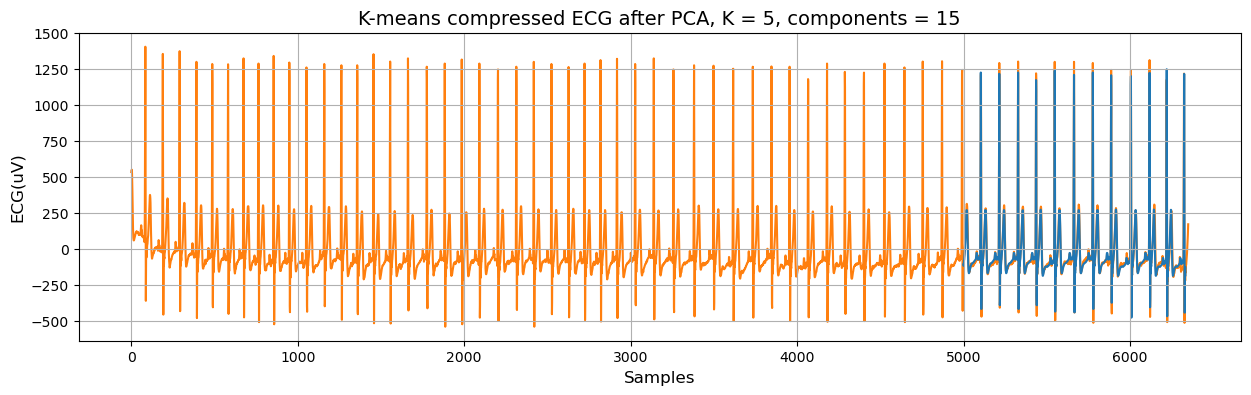

In [34]:
fig8 = plt.figure(figsize=(15,4))
plt.plot(x_axis, ecg_kmeans_sig2, zorder=1)
plt.plot(ecg_signal, zorder=0)
plt.title('K-means compressed ECG after PCA, K = ' + str(K) + ', components = ' + str(num_components), fontsize=14)
plt.xlabel('Samples', fontsize=12)
plt.ylabel('ECG(uV)', fontsize=12)
plt.grid()
plt.show()

# Conclusions
Both K-means and PCA techniques can be used for compression. With PCA you can control the number of components or the amount of variance you want to keep.
With K-means you control the number of clusters K and you have a more clear visualization of which samples are outliers.
The two approaches can also be combined: clustering in the transformed space may reduce the overall RMSE.
Depending on your application you should take into account both the compression error and the computational cost of each approach to design the most appropriate solution to your problem.

You can now play with the notebook modifying it...enjoy!